# Ciencia de Datos
*Práctica 3 de Sistemas de la Información II*

Por Carlos Moragón y Paloma Pérez de Madrid

---

### Introducción

Esta práctica tiene como objetivo principal la aplicación de técnicas de aprendizaje automático para predecir si la calidad de un plátano es **buena** o **mala** en función de atributos como la acidez, la dulzura, tamaño, peso, ...

El conjunto de datos lo hemos obtenido de Kaggle: https://www.kaggle.com/datasets/l3llff/banana?resource=download
*Nota*: Para comenzar la práctica, debe descargarse dicho conjunto de datos y subirlos al notebook (icono de la carpeta en el menú del lazo izquierdo)

### Objetivos

1. Explorar y comprender el conjunto de datos proporcionado.
2. Preprocesar los datos para su posterior modelado.
3. Implementar el algoritmo de XGBoost para la predicción de la calidad del plátano
4. Evaluar el rendimiento del modelo de XGBoost utilizando métricas de evaluación pertinentes.

### Pasos a Seguir

1. **Exploración de Datos**: Se realizó un análisis exploratorio de los datos para comprender la distribución, la relación entre las variables y la presencia de valores atípicos.

2. **Preprocesamiento de Datos**: Escalado de características para normalizar su distribución, codificación de la variable categórica Quality mediante técnicas como one-hot encoding, eliminación de observaciones con valores NaN para garantizar la integridad del conjunto de datos, la identificación y eliminación de valores atípicos utilizando métodos basados en quantiles, la ingeniería de características para capturar información relevante, la eliminación de características con baja variabilidad o correlación y el balanceo de clases mediante técnicas como submuestreo o sobremuestreo para abordar el desequilibrio de clases.

3. **Implementación de XGBoost**: Se implementó el algoritmo de XGBoost utilizando la biblioteca correspondiente en h2o. Además se implementaron otros modelos para demostrar el rendimiento superior de XGBoost respecto al resto

4. **Evaluación del Modelo**: Se evaluó el rendimiento del modelo de XGBoost utilizando métricas de evaluación como Matriz de Consfusión,Curva ROC,Umbral,LIFT, SCORER y otras evaluaciones comunes como Precisión, RecallF1-Score, Exactitud (Accuracy), Especificidad, AUC-PR (Área bajo la curva Precision-Recall).

### Conclusiones

La práctica proporciona una visión completa del proceso de construcción y evaluación de modelos predictivos utilizando exclusivamente XGBoost en el contexto de etiquetar si un plátano tiene es bueno o malo.

In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 2.2 MB/s eta 0:00:00


In [ ]:
import h2o
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

Descargamos los datos de nuestro kaggle.

In [ ]:
df = pd.read_csv('banana_quality.csv')
# https://www.kaggle.com/datasets/l3llff/banana?resource=download

print(df)

FileNotFoundError: [Errno 2] No such file or directory: 'banana_quality.csv'

¿Qué significan estos datos?
* Size - Tamaño de la fruta
* Weight - Peso de la fruta
* Sweetness - Dulzura de la fruta
* Softness - Suavidad de la fruta
* HarvestTime - Cantidad de tiempo transcurrido desde la cosecha de la fruta
* Ripeness - Madurez de la fruta
* Acidity - Acidez de la fruta
* Quality - Calidad de la fruta

¿Podríamos añadir alguna variable más?

## Análisis de datos.

Plots:
* Histograma de la distribución de Calidad
* Matriz de Correlación
* Histograma distribución de la dulzura
* Box Plot de la Acidez por Calidad

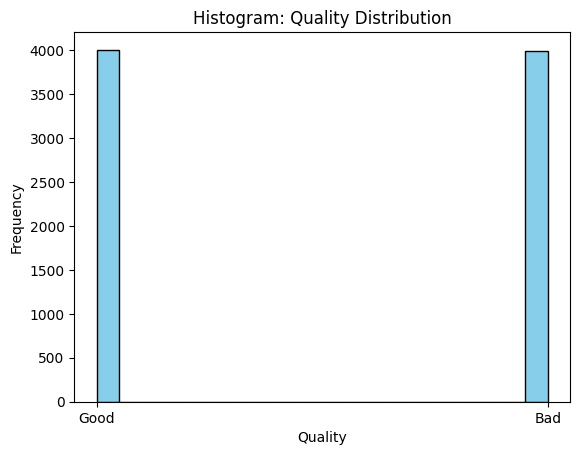

In [ ]:
plt.hist(df['Quality'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Histogram: Quality Distribution')
plt.show()


Dado el gráfico, podemos suponer que la distribución de plátanos de buena y mala calidad es equiparable, luego no hay sesgo.

La matriz de correlación es una medida que varía en el rango de -1 a 1.

Un valor de 1 indica una correlación perfecta positiva, lo que significa que cuando una variable aumenta, la otra variable también aumenta en proporción constante.
Un valor de -1 indica una correlación perfecta negativa, lo que significa que cuando una variable aumenta, la otra variable disminuye en proporción constante.
Un valor de 0 indica que no hay correlación entre las variables.

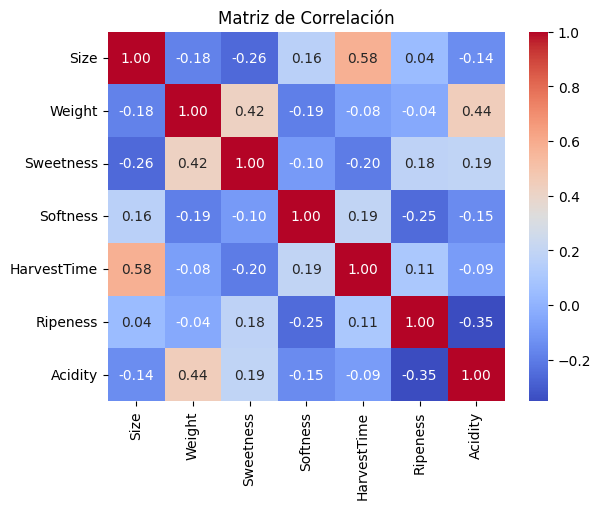

In [ ]:
# Eliminar la columna 'Quality' del DataFrame antes de calcular la matriz de correlación
numeric_df = df.drop(columns=['Quality'])

# Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

# Visualizar la matriz de correlación como un mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


Conclusiones del gráfico:
* El tiempo de cosecha está altamente relacionado con el tamaño
* Hay una tendencia moderada de que los plátanos más ácidos tiendan a tener un peso ligeramente mayor y al revés
* Hay una tendencia moderada de que los plátanos más ácidos tiendan a tener una dulzura ligeramente mayor y al revés

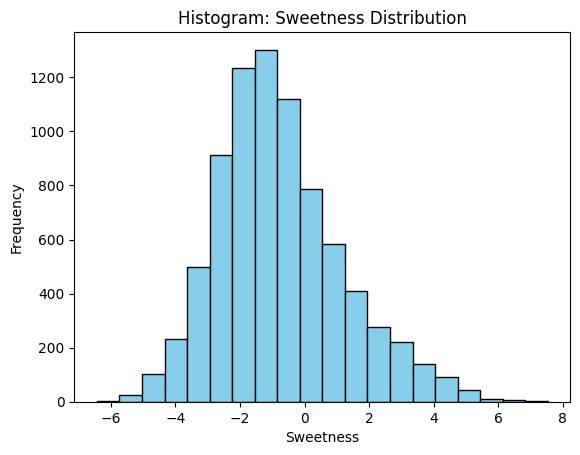

In [ ]:
plt.hist(df['Sweetness'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sweetness')
plt.ylabel('Frequency')
plt.title('Histogram: Sweetness Distribution')
plt.show()


La mayoría de las personas consideran que un plátano es bueno cuanto más dulce es.

Para ello visualizaremos que cantidad de plátanos dulces se consideran buenos

In [ ]:
# Primero averiguaremos el valor máximo y el valor mínimo de la columna de la dulzura
umbral_alta_dulzura = df['Sweetness'].quantile(0.75)
valor_maximo = df['Sweetness'].max()
valor_minimo = df['Sweetness'].min()

print(f'Umbral de alta dulzura, cuantil 75% : {umbral_alta_dulzura}')
print("Valor máximo de dulzura:", valor_maximo)
print("Valor mínimo de dulzura:", valor_minimo)


Umbral de alta dulzura, cuantil 75% : 0.311047995
Valor máximo de dulzura: 7.539374
Valor mínimo de dulzura: -6.4340215


Por tanto consideraremos que
* 7.539374 = puntuación de 10
* -6.4340215 = puntuación de 0

El 75% de los datos está por debajo de 0.311047995

Diremos que un plátano es altamente dulce si tiene una puntuación de mayor a 0.311047995

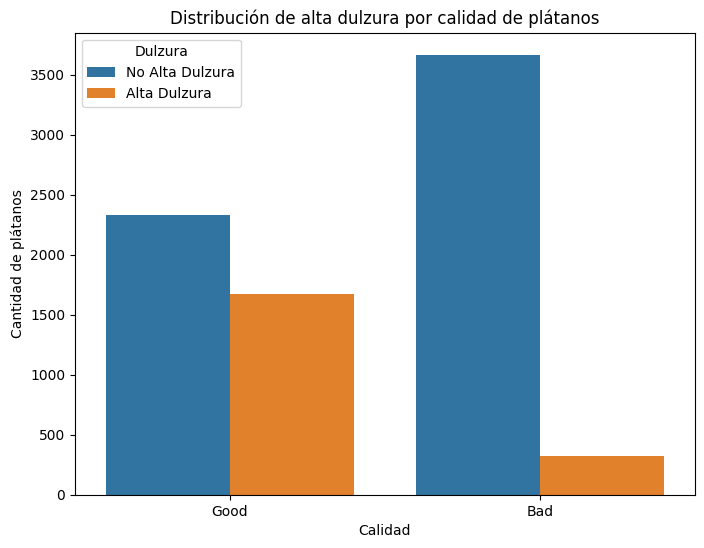

Plátanos con alta dulzura y buena calidad: 1674
Plátanos con alta dulzura y mala calidad: 326


In [ ]:
# Rango de alta dulzura

# Conteo de plátanos con alta dulzura por calidad
alta_dulzura_buena_calidad = df[(df['Quality'] == 'Good') & (df['Sweetness'] >= umbral_alta_dulzura)].shape[0]
alta_dulzura_mala_calidad = df[(df['Quality'] == 'Bad') & (df['Sweetness'] >= umbral_alta_dulzura)].shape[0]

# Gráfico de barras
plt.figure(figsize=(8, 6))
sns.countplot(x='Quality', hue=pd.cut(df['Sweetness'], bins=[df['Sweetness'].min(), umbral_alta_dulzura, df['Sweetness'].max()], labels=['No Alta Dulzura', 'Alta Dulzura']), data=df)
plt.title('Distribución de alta dulzura por calidad de plátanos')
plt.xlabel('Calidad')
plt.ylabel('Cantidad de plátanos')
plt.legend(title='Dulzura')
plt.show()


print(f'Plátanos con alta dulzura y buena calidad: {alta_dulzura_buena_calidad}')
print(f'Plátanos con alta dulzura y mala calidad: {alta_dulzura_mala_calidad}')


In [ ]:
# Conteo total de plátanos por calidad
total_buena_calidad = df[df['Quality'] == 'Good'].shape[0]
total_mala_calidad = df[df['Quality'] == 'Bad'].shape[0]

# Porcentaje de plátanos con alta dulzura respecto al total por calidad
porcentaje_alta_dulzura_buena_calidad = (alta_dulzura_buena_calidad / total_buena_calidad) * 100
porcentaje_alta_dulzura_mala_calidad = (alta_dulzura_mala_calidad / total_mala_calidad) * 100

print(f'Porcentaje de plátanos con alta dulzura y buena calidad: {porcentaje_alta_dulzura_buena_calidad:.2f}%')
print(f'Porcentaje de plátanos con alta dulzura y mala calidad: {porcentaje_alta_dulzura_mala_calidad:.2f}%')


Porcentaje de plátanos con alta dulzura y buena calidad: 41.79%
Porcentaje de plátanos con alta dulzura y mala calidad: 8.16%


Como se observa, menos de la mitad de plátanos con alta dulzura son de buena calidad. Por tanto, descartamos la hipótesis de que si un plátano es dulce, su calidad será favorable


**Calcular el efecto de cada variable predictora** en la probabilidad de que un plátano sea de buena calidad

In [ ]:
import statsmodels.api as sm

# Variables predictoras (X) y variable objetivo (y)
X = df.drop(columns=['Quality'])  # Todas las columnas excepto 'Quality'
y = (df['Quality'] == 'Good').astype(int)  # Convertir 'Good' a 1 y 'Bad' a 0 para análisis de regresión logística

X = sm.add_constant(X)  # constante a las variables predictoras para el término de intercepción

modelo = sm.Logit(y, X).fit() # Ajustar modelo de regresión logística

print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.289152
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                Quality   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7992
Method:                           MLE   Df Model:                            7
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                  0.5828
Time:                        06:39:56   Log-Likelihood:                -2313.2
converged:                       True   LL-Null:                       -5545.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.7007      0.064     26.698      0.000       1.576       1.826
Size            0.6694    

- **Coeficientes:**
  - **Tamaño (Size):** Por cada unidad de aumento en el tamaño del plátano, la probabilidad de que sea de buena calidad aumenta en aproximadamente un 66.94%, manteniendo todas las demás variables constantes.
  - **Peso (Weight):** Por cada unidad de aumento en el peso del plátano, la probabilidad de que sea de buena calidad aumenta en aproximadamente un 98.41%, manteniendo todas las demás variables constantes.
  - **Dulzura (Sweetness):** Por cada unidad de aumento en la dulzura del plátano, la probabilidad de que sea de buena calidad aumenta en aproximadamente un 78.74%, manteniendo todas las demás variables constantes.
  - **Suavidad (Softness):** Por cada unidad de aumento en la suavidad del plátano, la probabilidad de que sea de buena calidad aumenta en aproximadamente un 8.02%, manteniendo todas las demás variables constantes.
  - **Tiempo de Cosecha (HarvestTime):** Por cada unidad de aumento en el tiempo de cosecha del plátano, la probabilidad de que sea de buena calidad aumenta en aproximadamente un 57.58%, manteniendo todas las demás variables constantes.
  - **Madurez (Ripeness):** Por cada unidad de aumento en la madurez del plátano, la probabilidad de que sea de buena calidad aumenta en aproximadamente un 59.93%, manteniendo todas las demás variables constantes.
  - **Acidez (Acidity):** Por cada unidad de aumento en la acidez del plátano, la probabilidad de que sea de buena calidad disminuye en aproximadamente un 11.15%, manteniendo todas las demás variables constantes.

- **Significancia estadística (p-valores):**
  - Todos los coeficientes tienen p-valores prácticamente cero, lo que indica una alta significancia estadística de las variables predictoras.

- **Intervalos de confianza (95%):**
  - Para cada coeficiente, se proporcionan los intervalos de confianza del 95%, que representan el rango de valores plausibles para el coeficiente en la población.
- **Dirección del efecto**: Las direcciones de los coeficientes (positivos o negativos) nos indican cómo cada variable influye en la calidad del plátano. Por ejemplo, un tamaño, peso, dulzura, suavidad, tiempo de cosecha y madurez mayores están asociados con una mayor probabilidad de que el plátano sea de buena calidad, mientras que un nivel más alto de acidez está asociado con una menor probabilidad de buena calidad.

El modelo de regresión logística muestra que las variables predictoras (tamaño, peso, dulzura, suavidad, tiempo de cosecha, madurez y acidez) son significativas para predecir la calidad del plátano, con coeficientes positivos para la mayoría de las variables, lo que indica una asociación positiva con la calidad del plátano.

_________________________________________________________
Dada la importancia del Peso, vamos a visualizar el impacto del peso como hemos hecho con la dulzura

In [ ]:
umbral_alto_peso = df['Weight'].quantile(0.75)
valor_maximo = df['Weight'].max()
valor_minimo = df['Weight'].min()

print(f'Umbral de alto peso, cuantil 75% : {umbral_alto_peso}')
print("Valor máximo del peso:", valor_maximo)
print("Valor mínimo del peso:", valor_minimo)

Umbral de alto peso, cuantil 75% : 0.775491475
Valor máximo del peso: 5.679692
Valor mínimo del peso: -8.283002


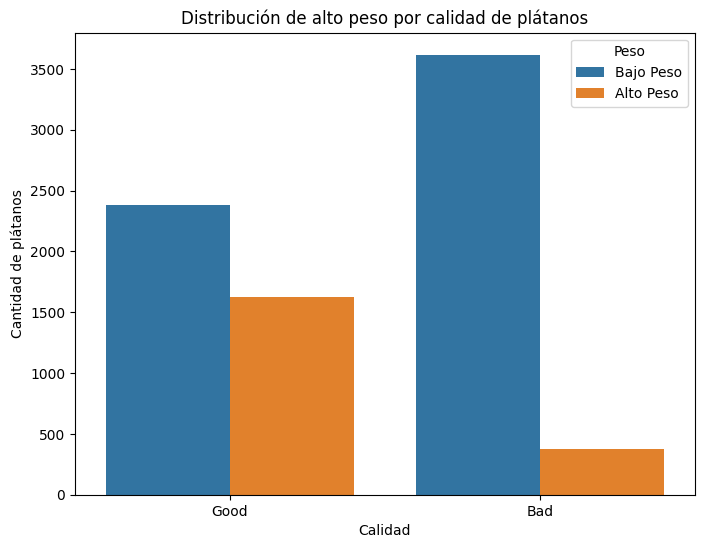

Plátanos con alto peso y buena calidad: 1624
Plátanos con alto peso y mala calidad: 376


In [ ]:
# Rango de alta dulzura

# Conteo de plátanos con alto peso por calidad
alto_peso_buena_calidad = df[(df['Quality'] == 'Good') & (df['Weight'] >= umbral_alto_peso)].shape[0]
alto_peso_mala_calidad = df[(df['Quality'] == 'Bad') & (df['Weight'] >= umbral_alto_peso)].shape[0]

# Gráfico de barras
plt.figure(figsize=(8, 6))
sns.countplot(x='Quality', hue=pd.cut(df['Weight'], bins=[df['Weight'].min(), umbral_alto_peso, df['Weight'].max()], labels=['Bajo Peso', 'Alto Peso']), data=df)
plt.title('Distribución de alto peso por calidad de plátanos')
plt.xlabel('Calidad')
plt.ylabel('Cantidad de plátanos')
plt.legend(title='Peso')
plt.show()


print(f'Plátanos con alto peso y buena calidad: {alto_peso_buena_calidad}')
print(f'Plátanos con alto peso y mala calidad: {alto_peso_mala_calidad}')

In [ ]:
# Porcentaje de plátanos con alto peso respecto al total por calidad
porcentaje_alto_peso_buena_calidad = (alto_peso_buena_calidad / total_buena_calidad) * 100
porcentaje_alto_peso_mala_calidad = (alto_peso_mala_calidad / total_mala_calidad) * 100

print(f'Porcentaje de plátanos con alta dulzura y buena calidad: {porcentaje_alta_dulzura_buena_calidad:.2f}%')
print(f'Porcentaje de plátanos con alta dulzura y mala calidad: {porcentaje_alta_dulzura_mala_calidad:.2f}%')


Porcentaje de plátanos con alta dulzura y buena calidad: 41.79%
Porcentaje de plátanos con alta dulzura y mala calidad: 8.16%


**Nuevas variables**

Después de una evaluación exhaustiva de los datos y las variables disponibles, así como de las posibles variables adicionales, determinamos que no existe información adicional relevante que pueda ser capturada por nuevas variables y que mejore significativamente la capacidad predictiva del modelo, entonces es justificable no añadir nuevas variables. Hemos mantenido el modelo simple para evitar el riesgo de sobreajuste y mantener la interpretabilidad del modelo.

## Transformaciones / Tratamiento de datos.

* Escalamos las características.
* Analizamos los valores NA.
* Analizamos los valores atípicos.
* Analizamos la creación nuevas variables.
* Analizamos la elimincación de características irrelevantes.
* Analizamos la necesidad de balanceo de clases.

Al **escalar las características**, las estamos transformando de manera que tengan una media cercana a cero y una desviación estándar de uno (en el caso del `StandardScaler`). Esto ayuda a evitar que una variable con un rango de valores mucho más grande domine sobre las demás variables durante el ajuste del modelo.


In [ ]:
# Hacer esto con los datos de train
scaler = StandardScaler()
# df_mid = df.drop('Quality', axis=1).scale().as_data_frame()
scaler.fit(df.drop('Quality', axis=1))
scaled_features = scaler.transform(df.drop('Quality', axis=1))
df_transformado = pd.DataFrame(scaled_features, columns=df.columns[:-1])


Codificamos la variable Quality a (1 y 0)
* Algoritmos de aprendizaje automático, como la regresión logística o las máquinas de vectores de soporte (SVM), es necesario codificar las variables categóricas en forma numérica,
* Algoritmos como los árboles de decisión y sus variantes como Random Forest y XGBoost, no es necesario codificar la variable de calidad en forma numérica (ya que puede manejar variables categóricas directamente sin necesidad de codificación)

Como vamos a comparar varios modelos (XGBoost, RandomForest y Regresion) procedemos a codificar las variables




In [ ]:
# linea puede que no haga falta
# df_transformado = df

# A partir de aquí si hace falta 100%
label_encoder = LabelEncoder()
df_transformado['Quality_encoded'] = label_encoder.fit_transform(df['Quality'])

Analizamos los valores NA
* Si existen, en este caso tiene sentido borrar el registro, ya que queremos analizar en base a todas las características mencionadas anteriormente cuál es la calidad del plátano
* Si no existen, se deja el df como tal


In [ ]:
df_transformado.drop('Quality', axis=1)
df_transformado.isna().sum()

Size               0
Weight             0
Sweetness          0
Softness           0
HarvestTime        0
Ripeness           0
Acidity            0
Quality            0
Quality_encoded    0
dtype: int64

Analizamos los **valores atípicos**:
* Visualizaremos los boxplot para cada característica numérica, si vemos algún dato fuera del boxplot

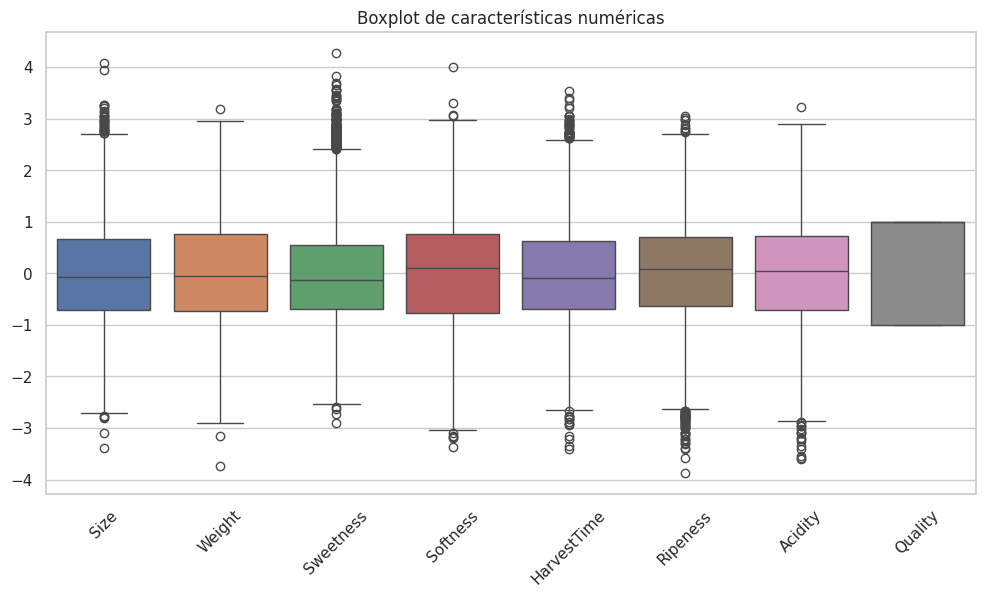

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
df_boxplot = df_transformado.copy()
df_boxplot = df_boxplot.drop(columns=('Quality_encoded'))
sns.boxplot(data=df_boxplot)
plt.title("Boxplot de características numéricas")
plt.xticks(rotation=45)
plt.show()

Vemos que hay bastantes valores atípicos, procedemos a tratarlos

Un método común para eliminar los valores atípicos es utilizar el rango intercuartílico (IQR). El IQR es la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1) de una distribución de datos. Los valores atípicos se definen generalmente como aquellos que están por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR.

no borrar los datos, asignarlo a un máximo o un mínimo o utilizas un algortimo LOF y ver cuanto te da. LOF: si un registro en si es anormal

In [ ]:
 # Calcular el rango intercuartílico (IQR)
df_numerico = df_transformado.drop(columns=['Quality'])
df_numerico = df_numerico.select_dtypes(include=['number'])
q1 = df_numerico.quantile(0.25)
q3 = df_numerico.quantile(0.75)
iqr = q3 - q1

# Definir los límites inferior y superior para identificar valores atípicos
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

# Eliminar los valores atípicos
df_transformado = df_numerico[~((df_numerico < lower_limit) | (df_numerico > upper_limit)).any(axis=1)]
df_transformado

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality_encoded
0,-0.551136,0.609729,1.975051,-0.705896,0.523951,0.782568,0.114491,1
1,-0.778107,0.619052,0.573385,-1.201237,-0.070585,0.608493,0.130204,1
2,0.182685,1.113298,1.200347,-1.273895,0.052101,1.092419,0.618577,1
3,-0.056521,1.154485,1.365182,-0.609815,-0.127716,0.516472,0.204566,1
4,0.655290,1.031953,0.383797,-0.578798,-0.340291,0.140598,1.222556,1
...,...,...,...,...,...,...,...,...
7995,-2.653041,0.736471,0.977850,1.436842,0.525518,-0.443697,1.041879,0
7996,0.748609,-0.722715,-1.048050,0.243907,-0.286557,-1.465351,0.917625,0
7997,1.016216,-0.568827,-0.904435,0.474274,0.094620,-1.237308,0.300279,0
7998,-0.648022,-0.983020,-0.122055,1.036948,-0.025716,-2.062933,0.180892,0


Conclusiones de los valores atípicos:

1. Hay una cantidad considerable de valores atípicos en las columnas numéricas del conjunto de datos, lo que puede afectar negativamente el rendimiento de algunos modelos de aprendizaje automático.

2. Se ha elegido utilizar el método del rango intercuartílico (IQR) para identificar y eliminar estos valores atípicos. Este método es comúnmente utilizado y ayuda a eliminar valores extremos que pueden distorsionar los resultados de análisis y modelos predictivos.

3. Después de aplicar el método del IQR, se ha creado un nuevo DataFrame `df_transformado` que contiene únicamente las filas que no contienen valores atípicos en ninguna de las columnas numéricas.

4. Este proceso de eliminación de valores atípicos puede mejorar la calidad de los datos y permitir un análisis más robusto y confiable.


**Eliminamos características irrelevantes**

Lo haremos en base a los coeficientes obtenidos del análisis de el efecto de cada variable predictora , consideraremos eliminar aquellas características que tienen un impacto menor en la probabilidad de que el plátano sea de buena calidad

En base a los coeficientes proporcionados:

- La suavidad (Softness) parece tener el menor impacto en la probabilidad de buena calidad, con un coeficiente de aproximadamente 0.0802, lo que indica un aumento del 8.02% en la probabilidad de buena calidad por cada unidad de aumento en la suavidad. Aunque todavía contribuye al modelo, su impacto es el más bajo de todas las características.

- Otro enfoque sería establecer un umbral arbitrario para la importancia de las características y eliminar aquellas que caen por debajo de ese umbral. Por ejemplo, podríamos decidir eliminar características con coeficientes inferiores a 0.05 o 0.1 si consideramos que su impacto es demasiado bajo en comparación con otras características.

En este caso nos decantaremos por el umbral arbitrario. Consideramos que no es óptimo eliminar datos ya que el dataset es en sí de un tamaño reducido. Además, el coeficiente de la siavidad es del 8.02%, lo que nos indica que contribuye al modelo lo suficiente.

_______________________________________________________


In [ ]:
umbral_coeficiente = 0.05  # Puedes ajustar este umbral según tus necesidades

caracteristicas_a_eliminar = []

for caracteristica, coeficiente in modelo.params.items():
    if abs(coeficiente) < umbral_coeficiente:
        caracteristicas_a_eliminar.append(caracteristica)

df_sin_caracteristicas_irrelevantes = df.drop(columns=caracteristicas_a_eliminar)

print("Características eliminadas:", caracteristicas_a_eliminar)
print(df_sin_caracteristicas_irrelevantes.head())


Características eliminadas: []
       Size    Weight  Sweetness  Softness  HarvestTime  Ripeness   Acidity  \
0 -1.924968  0.468078   3.077832 -1.472177     0.294799  2.435570  0.271290   
1 -2.409751  0.486870   0.346921 -2.495099    -0.892213  2.067549  0.307325   
2 -0.357607  1.483176   1.568452 -2.645145    -0.647267  3.090643  1.427322   
3 -0.868524  1.566201   1.889605 -1.273761    -1.006278  1.873001  0.477862   
4  0.651825  1.319199  -0.022459 -1.209709    -1.430692  1.078345  2.812442   

  Quality  Quality_encoded  
0    Good                1  
1    Good                1  
2    Good                1  
3    Good                1  
4    Good                1  


Conclusión: No se eliminaron características.

Explicación: Ninguna característica tuvo un coeficiente por debajo del umbral establecido, lo que sugiere que todas las características tienen un impacto significativo en la calidad del plátano según el modelo de regresión logística.

____________________________________________________

El balanceo de clases no es necesario al tener igual de casos en 'Good' que en 'Bad', pero lo ponemos para saber como hacerlo :)

In [ ]:
X = df_sin_caracteristicas_irrelevantes.drop(columns=['Quality', 'Quality_encoded'])
y = df_sin_caracteristicas_irrelevantes['Quality_encoded']

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Mostrar las dimensiones de los datos después de aplicar SMOTE
print("Dimensiones de X después de SMOTE:", X_resampled.shape)
print("Dimensiones de y después de SMOTE:", y_resampled.shape)


Dimensiones de X después de SMOTE: (8012, 7)
Dimensiones de y después de SMOTE: (8012,)


## Modelo

In [ ]:
# TIENES QUE COMPARAR VARIOS MODELOS Y SUS

In [ ]:
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ODeepLearningEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

Crearemos 3 modelos para comparar sus competencias al hacer comparaciones:
* Deep Learning (Neural Networks)
* Distributed Random Forest (DRF)
* XGBoost

In [ ]:
h2o.init()

data = h2o.H2OFrame(df_transformado) # sobre df??

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8w6zth_m
  JVM stdout: /tmp/tmp8w6zth_m/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8w6zth_m/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 4 days
H2O_cluster_name:,H2O_from_python_unknownUser_x1nqea
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


<h1>Creación de subconjuntos de datos</h1>

In [ ]:
# Size	Weight	Sweetness	Softness	HarvestTime	Ripeness	Acidity	Quality_encoded	Size_HarvestTime
predictors = ["Size", "Weight", "Sweetness", "Softness", "HarvestTime", "Ripeness", "Acidity"]#, "Size_HarvestTime"] #<- Ya no está Size_harvesttime
response = "Quality_encoded"

data[response] = data[response].asfactor() # Calidad --> Categoría

# Dividir los datos en train + dev + test
train, test, dev = data.split_frame(ratios=[0.75, 0.15], destination_frames = ['train_df', 'test_df', 'val_df'],
                                    seed=566)


In [ ]:
# train = train.drop('Quality', axis=1)

In [ ]:
train

Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality_encoded
-0.551136,0.609729,1.97505,-0.705896,0.523951,0.782568,0.114491,1
-0.778107,0.619052,0.573385,-1.20124,-0.0705848,0.608493,0.130204,1
-0.0565206,1.15449,1.36518,-0.609815,-0.127716,0.516472,0.204566,1
0.65529,1.03195,0.383797,-0.578798,-0.340291,0.140598,1.22256,1
0.242332,1.75835,1.25821,-0.249548,-0.604637,0.268213,0.947551,1
0.374943,1.02739,0.259753,-1.43086,0.528551,1.47021,0.83835,1
-0.393322,1.09518,0.466585,-1.37744,-0.505843,0.781696,0.765004,1
-0.601181,1.06051,1.56219,-1.0611,0.582731,1.40795,1.34814,1
1.3156,1.15217,1.71459,-0.89601,0.154815,0.694777,2.04707,1
-0.0531023,1.08543,2.11464,-0.00372393,-0.531828,-0.405449,0.161794,1


In [ ]:
'''
scaler = StandardScaler()
df_train = train.drop('Quality', axis=1).scale().as_data_frame() # No nos hace falta Quality, para eso tenemos Quality_encoded
print(df_train)
scaler.fit(df_train)
scaled_features = scaler.transform(df_train)
# con los datos de train --> transform de scaler [BORRAR MORAGÓN]
df_transformado = pd.DataFrame(scaled_features, columns=df.columns[:-1])
'''

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


          Size    Weight  Sweetness  Softness  HarvestTime  Ripeness  \
0    -0.550471  0.611322   1.973285 -0.700252     0.535556  0.785441   
1    -0.775895  0.620629   0.570009 -1.195323    -0.061030  0.610958   
2    -0.059227  1.155169   1.362715 -0.604223    -0.118358  0.518721   
3     0.647732  1.032841   0.380204 -0.573223    -0.331667  0.141965   
4     0.237588  1.758024   1.255618 -0.244153    -0.596924  0.269879   
...        ...       ...        ...       ...          ...       ...   
6011 -2.638049  0.737852   0.974938  1.441318     0.537128 -0.443702   
6012  0.740414 -0.718901  -1.053288  0.249034    -0.277747 -1.467753   
6013  1.006198 -0.565269  -0.909508  0.479275     0.104745 -1.239176   
6014 -0.646696 -0.978772  -0.126230  1.041642    -0.016007 -2.066739   
6015 -0.892669 -0.633119   0.473460  0.738072    -0.407641 -1.130648   

       Acidity  Quality_encoded  
0     0.108183                1  
1     0.123897                1  
2     0.198265                1  

<h1>Deep Learning (Neural Networks)</h1>

In [ ]:
#df_train = h2o.H2OFrame(df_transformado)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
#dev['Quality_encoded'] = dev['Quality_encoded'].asfactor() #Se está tratando Quality_encoded como numeros en vez de categorias

In [ ]:
# Deep Learning (Neural Networks)
rrnn = H2ODeepLearningEstimator()

rrnn.train(x=predictors, y=response, training_frame=train, validation_frame=dev)

deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1713422558819_1


Status of Neuron Layers: predicting Quality_encoded, 2-class classification, bernoulli distribution, CrossEntropy loss, 42,202 weights/biases, 503.7 KB, 57,550 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate             rate_rms             momentum    mean_weight             weight_rms           mean_bias                bias_rms
--  -------  -------  ---------  ---------  ----  ----  --------------------  -------------------  ----------  ----------------------  -------------------  -----------------------  ---------------------
    1        7        Input      0.0
    2        200      Rectifier  0.0        0.0   0.0   0.03371243054101277   0.06393617391586304  0.0         -0.0014784305883251494  0.10044452548027039  0.4277647256402183       0.04742306470870972
    3        200      Rectifier  0.0        0.0   0.0   0.09759196997453982   0.20088398456573486  0.0         -0.0036943199017398514  0.07015234231948853  0.9917740234471811       0.015256915241479874
    4        2        Softmax               0.0   0.0   0.011293448503420223  0.06976842880249023  0.0         0.00553726479778561     0.38162875175476074  -0.00038449946121550584  0.0066866446286439896

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.41668257512354895
RMSE: 0.6455095468879983
LogLoss: 2.052763635699721
Mean Per-Class Error: 0.08697210838522777
AUC: 0.9709477555276916
AUCPR: 0.9664079620412735
Gini: 0.9418955110553833

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9993339497861512
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      2692  266   0.0899   (266.0/2958.0)
1      235   2562  0.084    (235.0/2797.0)
Total  2927  2828  0.0871   (501.0/5755.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.999334     0.910933  4
max f2                       0.998253     0.937587  7
max f0point5                 0.999829     0.931577  1
max accuracy                 0.999334     0.912945  4
max precision                0.999967     0.987924  0
max recall                   0.410059     1         300
max specificity              0.999967     0.992901  0
max absolute_mcc             0.999334     0.825855  4
max min_per_class_accuracy   0.999334     0.910074  4
max mean_per_class_accuracy  0.999334     0.913028  4
max tns                      0.999967     2937      0
max fns                      0.999967     1079      0
max fps                      0.00822539   2958      399
max tps                      0.410059     2797      300
max tnr                      0.999967     0.992901  0
max fnr                      0.999967     0.38577   0
max fpr                      0.00822539   1         399
max tpr                      0.410059     1         300

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 93.42 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100782                   0.999998           2.05756     2.05756            1                0.999998  1                           0.999998            0.0207365       0.0207365                  105.756   105.756            0.0207365
2        0.0201564                   0.999997           2.05756     2.05756            1                0.999997  1           

In [ ]:
# Verificar el rendimiento del modelo en los datos de prueba
rendimiento_antes_rrnn= rrnn.model_performance(test_data=test)
print(rendimiento_antes_rrnn)

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4201943126541603
RMSE: 0.6482239679726138
LogLoss: 2.10411467638893
Mean Per-Class Error: 0.08384502045694556
AUC: 0.9689304210905734
AUCPR: 0.9681751914426258
Gini: 0.9378608421811467

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9994321837852118
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      534  40   0.0697   (40.0/574.0)
1      54   497  0.098    (54.0/551.0)
Total  588  537  0.0836   (94.0/1125.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.999432     0.913603  19
max f2                       0.997673     0.929867  47
max f0point5                 0.999633     0.921212  14
max accuracy                 0.999432     0.916444  19
max precision                0.999994     1         0
max recall                  

In [ ]:
## Modelo Final ##

print(f'mi modelo es {rrnn}')
print("\n \n ****************************************************\n \n")
print(f'su rendimiento: {rendimiento_antes_rrnn}')

mi modelo es Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_model_python_1713422558819_1


Status of Neuron Layers: predicting Quality_encoded, 2-class classification, bernoulli distribution, CrossEntropy loss, 42,202 weights/biases, 503.7 KB, 57,550 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate             rate_rms             momentum    mean_weight             weight_rms           mean_bias                bias_rms
--  -------  -------  ---------  ---------  ----  ----  --------------------  -------------------  ----------  ----------------------  -------------------  -----------------------  ---------------------
    1        7        Input      0.0
    2        200      Rectifier  0.0        0.0   0.0   0.03371243054101277   0.06393617391586304  0.0         -0.0014784305883251494  0.10044452548027039  0.4277647256402183       0.04742306470870972
    3        200      Rectifier  0.0        0.0   

<h1>Distributed Random Forest (DRF)</h1>

In [ ]:
drf = H2ORandomForestEstimator()

drf.train(x=predictors, y=response, training_frame=train, validation_frame=dev)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1713422558819_55


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          211748                 15           20           18.54         302           381           332.72

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.030200476808221712
RMSE: 0.17378284382591314
LogLoss: 0.20313271578440795
Mean Per-Class Error: 0.033164638631703096
AUC: 0.9913997973778049
AUCPR: 0.9899025612119959
Gini: 0.9827995947556099

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43333333333333335
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      2839  119   0.0402   (119.0/2958.0)
1      73    2724  0.0261   (73.0/2797.0)
Total  2912  2843  0.0334   (192.0/5755.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433333     0.965957  117
max f2                       0.315789     0.975541  143
max f0point5                 0.615385     0.973216  83
max accuracy                 0.433333     0.966638  117
max precision                0.96         0.995302  3
max recall                   0            1         274
max specificity              1            0.997634  0
max absolute_mcc             0.433333     0.933372  117
max min_per_class_accuracy   0.47619      0.964962  105
max mean_per_class_accuracy  0.433333     0.966835  117
max tns                      1            2951      0
max fns                      1            1325      0
max fps                      0            2958      274
max tps                      0            2797      274
max tnr                      1            0.997634  0
max fnr                      1            0.473722  0
max fpr                      0            1         274
max tpr                      0            1         274

Gains/Lift Table: Avg response rate: 48.60 %, avg score: 48.71 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.256994                    1                  2.04782     2.04782            0.995267         1           0.995267                    1                   0.526278        0.526278                   104.782   104.782            0.523912
2        0.310165                    0.944444           2.04411     2.04719            0.993464         0.95028     0.994958                    0.991477            0.108688        0.634966                   104.411   104.719            0.631923
3        0.40278                     0.85               2.03054     2.04336            0.986867         0.90447     0.993097                    0.97147             0.188059        0.823025                   103.054   104.336            0.817616
4        0.500261                    0.388889           1.59544     1.95608            0.775401         0.670011    0.950677                    0.912728            0.155524        0.978548                   59.5436   95.6077            0.930543
5        0.609209                    0.111111           0.150953    1.63326            0.0733652        0.205594    0.793782      

In [ ]:
# Verificar el rendimiento del modelo en los datos de prueba
rendimiento_antes_drf= drf.model_performance(test_data=test)
print(rendimiento_antes_drf)

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.030283605917742092
RMSE: 0.17402185471297016
LogLoss: 0.1478742011005409
Mean Per-Class Error: 0.031251383294232216
AUC: 0.9928922390079488
AUCPR: 0.9912704029912577
Gini: 0.9857844780158975

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48666666626930233
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      560  14   0.0244   (14.0/574.0)
1      21   530  0.0381   (21.0/551.0)
Total  581  544  0.0311   (35.0/1125.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486667     0.968037  28
max f2                       0.42         0.969259  32
max f0point5                 0.66         0.978715  18
max accuracy                 0.486667     0.968889  28
max precision                0.8          0.997942  11
max recall                   

<h1>XGBOOST</h1>

In [ ]:

# Crear un modelo XGBoost
xgb = H2OXGBoostEstimator()
xgb.train(x=predictors, y=response, training_frame=train, validation_frame=dev)

**Búsqueda de Hiperparámetros**:

Es un proceso para encontrar la mejor configuración de ajustes *previos* (hiperparámetros) para un modelo de aprendizaje automático. Implica probar diferentes combinaciones de valores de hiperparámetros y evaluar el rendimiento del modelo para cada combinación.

**Objetivo**: es optimizar métricas de evaluación como precisión, área bajo la curva ROC o pérdida logarítmica.

**Cómo**:
1. Definir los hiperparámetros a probar (número de árboles, profundidad, tasa de aprendizaje, ...)
2. Crear el *grid* de búsqueda:  técnica utilizada para explorar de manera sistemática un espacio de hiperparámetros con el objetivo de encontrar la mejor combinación de valores para un modelo de aprendizaje automático
3. Entrenar el *grid*
4. Elegir el mejor modelo del *grid* de búsqueda

In [ ]:
# Verificar el rendimiento del modelo en los datos de prueba
rendimiento_antes_xgb= xgb.model_performance(test_data=test)
print(rendimiento_antes_xgb)

In [ ]:
# Ahora entrenaremos otro modelo para ver la influencia de los hiperparámetros

## Búsqueda de Hiperparámetros ##

# Definir los hiperparámetros a probar
hyper_parameters = {'ntrees': [50, 100, 150, 200, 300], 'max_depth': [3, 5, 7, 8, 9], 'learn_rate': [0.1, 0.01, 0.001, 0.0001, 0.00001]}

# Crear el grid de búsqueda
grid_search = H2OGridSearch(H2OXGBoostEstimator(), hyper_parameters)

# Entrenar el grid de búsqueda
grid_search.train(x=predictors, y=response, training_frame=train, validation_frame=dev)

# Obtener el mejor modelo del grid de búsqueda
best_model = grid_search.get_grid()[0]

## Verificar el rendimiento del mejor modelo ##
rendimiento_despues = best_model.model_performance(test_data=test)
print(rendimiento_despues)


xgboost Grid Build progress: |█ (cancelled)
Errors/Warnings building gridsearch model

Hyper-parameter: learn_rate, 0.001
Hyper-parameter: max_depth, 8
Hyper-parameter: ntrees, 100
failure_details: Job Canceled
failure_stack_traces: java.lang.RuntimeException: Error while training XGBoost model
	at hex.tree.xgboost.XGBoost$XGBoostDriver.buildModel(XGBoost.java:438)
	at hex.tree.xgboost.XGBoost$XGBoostDriver.computeImpl(XGBoost.java:388)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:253)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1704)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)
Caused by: water.Job$JobCancelledException: job XGBoost Grid Search [$03017f00000132d4ffffffff$_a93414992b5cf43339dc44e937e74430] was

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_a93414992b5cf43339dc44e937e74430> was cancelled by the user.

In [ ]:
# Vamos a comparar rápidamente el rendimiento antes y después

## Precisión ##
precision_antes = rendimiento_antes.precision()
print("Precisión antes de la búsqueda de hiperparámetros:", precision_antes)

precision_despues = rendimiento_despues.precision()
print("Precisión después de la búsqueda de hiperparámetros:", precision_despues)

# Comparar el rendimiento antes y después de la búsqueda de hiperparámetros
if precision_despues > precision_antes:
    print("El rendimiento mejoró después de la búsqueda de hiperparámetros.")
elif precision_despues < precision_antes:
    print("El rendimiento empeoró después de la búsqueda de hiperparámetros.")
else:
    print("El rendimiento se mantuvo igual antes y después de la búsqueda de hiperparámetros.")

## Curva ROC ##
auc_antes = rendimiento_antes.auc()
print("AUC antes de la búsqueda de hiperparámetros:", auc_antes)

auc_despues = rendimiento_despues.auc()
print("AUC después de la búsqueda de hiperparámetros:", auc_despues)

# Comparar el rendimiento antes y después de la búsqueda de hiperparámetros
if auc_despues > auc_antes:
    print("El rendimiento mejoró después de la búsqueda de hiperparámetros.")
elif auc_despues < auc_antes:
    print("El rendimiento empeoró después de la búsqueda de hiperparámetros.")
else:
    print("El rendimiento se mantuvo igual antes y después de la búsqueda de hiperparámetros.")


Precisión antes de la búsqueda de hiperparámetros: [[0.9998384594917298, 1.0]]
Precisión después de la búsqueda de hiperparámetros: [[0.9997668174596933, 1.0]]
El rendimiento empeoró después de la búsqueda de hiperparámetros.
AUC antes de la búsqueda de hiperparámetros: 0.992952267370872
AUC después de la búsqueda de hiperparámetros: 0.9925760286225402
El rendimiento empeoró después de la búsqueda de hiperparámetros.


Como se puede observar, el uso de hiperparámetros no mejora el modelo, luego no los usaremos

In [ ]:
## Modelo Final ##

print(f'mi modelo es {xgb}')
print("\n \n ****************************************************\n \n")
print(f'su rendimiento: {rendimiento_antes_xgb}')


mi modelo es Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1713422558819_12


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.005391206425532686
RMSE: 0.073424835209435
LogLoss: 0.02770223493549763
Mean Per-Class Error: 0.005405434152258662
AUC: 0.9997470848583784
AUCPR: 0.9997397684320636
Gini: 0.9994941697167568

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5116379857063293
       0     1     Error    Rate
-----  ----  ----  -------  -------------
0      2944  14    0.0047   (14.0/2958.0)
1      17    2780  0.0061   (17.0/2797.0)
Total  2961  2794  0.0054   (31.0/5755.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511638     0.994455  198
max f2                       0.335554     0.995213  212
max

## Evaluación
- Matriz de Consfusión
- Curva ROC
- Umbral
- LIFT
- SCORER

Otras evaluaciones comunes:

1. Precisión: La proporción de verdaderos positivos (TP) sobre el total de predicciones positivas (TP + FP).
2. Recall (Sensibilidad): La proporción de verdaderos positivos (TP) sobre el total de positivos reales (TP + FN).
3. F1-Score: La media armónica de precisión y recall. Es útil cuando hay un desequilibrio entre las clases.
4. Exactitud (Accuracy): La proporción de predicciones correctas (TP + TN) sobre el total de predicciones.
5. Especificidad: La proporción de verdaderos negativos (TN) sobre el total de negativos reales (TN + FP).
6. AUC-PR (Área bajo la curva Precision-Recall): La integral de la curva Precision-Recall. Es útil cuando hay desequilibrio de clases y te interesa más el rendimiento en la clase minoritaria.


Matriz de confusión:

In [ ]:
rendimiento_antes_xgb.confusion_matrix()

,0,1,Error,Rate
0,564.0,10.0,0.0174,(10.0/574.0)
1,20.0,531.0,0.0363,(20.0/551.0)
Total,584.0,541.0,0.0267,(30.0/1125.0)


In [ ]:
rendimiento_antes_rrnn.confusion_matrix()

,0,1,Error,Rate
0,534.0,40.0,0.0697,(40.0/574.0)
1,54.0,497.0,0.098,(54.0/551.0)
Total,588.0,537.0,0.0836,(94.0/1125.0)


In [ ]:
rendimiento_antes_drf.confusion_matrix()

,0,1,Error,Rate
0,560.0,14.0,0.0244,(14.0/574.0)
1,21.0,530.0,0.0381,(21.0/551.0)
Total,581.0,544.0,0.0311,(35.0/1125.0)


Curva ROC:

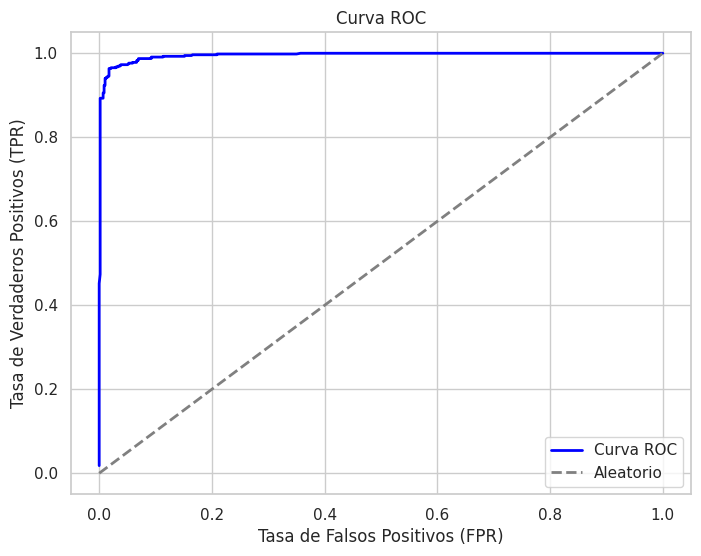

In [ ]:
roc_curve=rendimiento_antes_xgb.roc()


# Extraer los valores de tasa de verdaderos positivos (TPR) y tasa de falsos positivos (FPR)
fpr = roc_curve[0]
tpr = roc_curve[1]

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

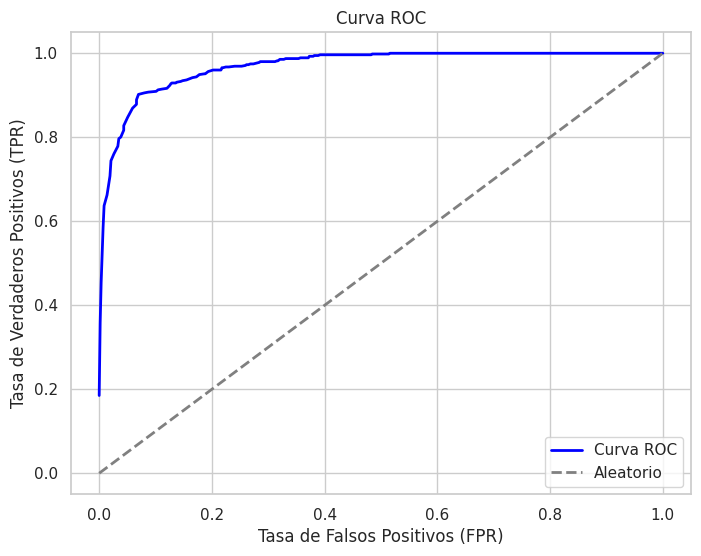

In [ ]:
roc_curve=rendimiento_antes_rrnn.roc()


# Extraer los valores de tasa de verdaderos positivos (TPR) y tasa de falsos positivos (FPR)
fpr = roc_curve[0]
tpr = roc_curve[1]

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

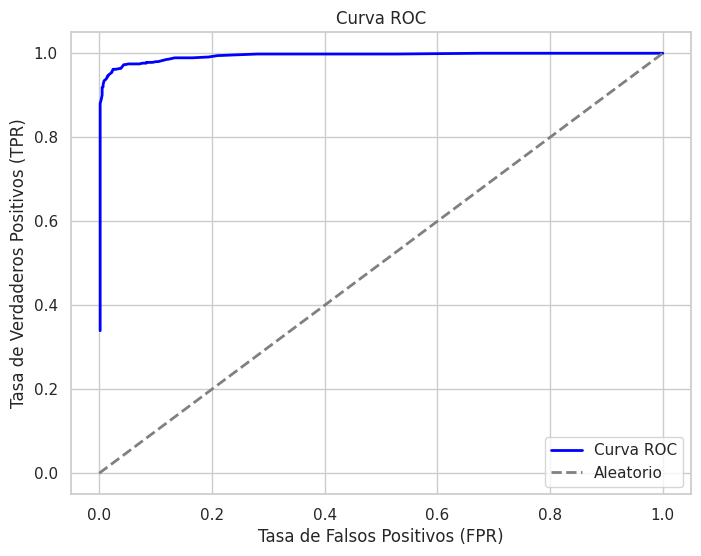

In [ ]:
roc_curve=rendimiento_antes_drf.roc()


# Extraer los valores de tasa de verdaderos positivos (TPR) y tasa de falsos positivos (FPR)
fpr = roc_curve[0]
tpr = roc_curve[1]

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.show()

Umbral:

In [ ]:
rendimiento_antes_xgb.find_threshold_by_max_metric('f1')


0.5226632356643677

In [ ]:
rendimiento_antes_rrnn.find_threshold_by_max_metric('f1')

0.9994321837852118

LIFT:

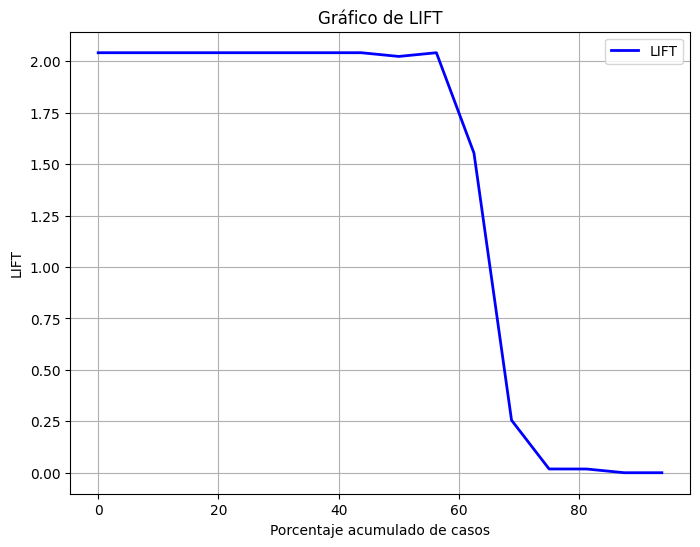

In [ ]:
# Obtener el valor de lift del rendimiento anterior
lift = rendimiento_antes_xgb.gains_lift()['lift']

# Crear un rango de valores para el eje x (porcentaje acumulado)
porcentaje_acumulado = [i * 100 / len(lift) for i in range(len(lift))]

# Graficar el gráfico de lift
plt.figure(figsize=(8, 6))
plt.plot(porcentaje_acumulado, lift, color='blue', lw=2, label='LIFT')
plt.xlabel('Porcentaje acumulado de casos')
plt.ylabel('LIFT')
plt.title('Gráfico de LIFT')
plt.legend()
plt.grid(True)
plt.show()

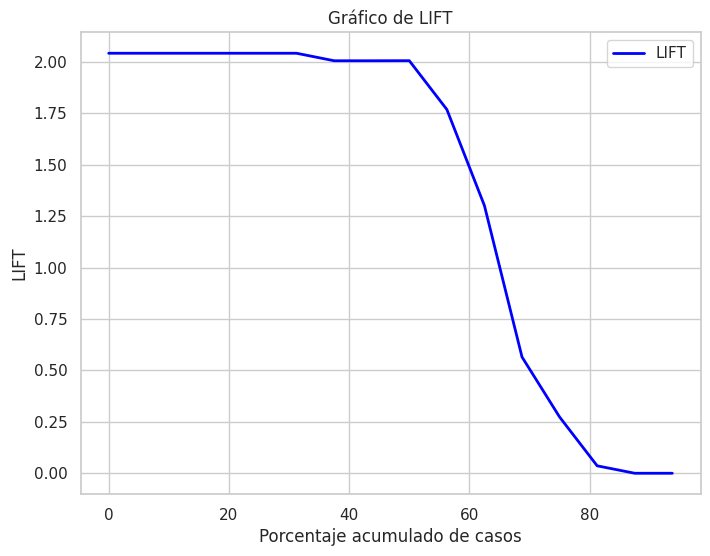

In [ ]:
# Obtener el valor de lift del rendimiento anterior
lift = rendimiento_antes_rrnn.gains_lift()['lift']

# Crear un rango de valores para el eje x (porcentaje acumulado)
porcentaje_acumulado = [i * 100 / len(lift) for i in range(len(lift))]

# Graficar el gráfico de lift
plt.figure(figsize=(8, 6))
plt.plot(porcentaje_acumulado, lift, color='blue', lw=2, label='LIFT')
plt.xlabel('Porcentaje acumulado de casos')
plt.ylabel('LIFT')
plt.title('Gráfico de LIFT')
plt.legend()
plt.grid(True)
plt.show()

<h1>Nuevo LIFT, según los déciles.</h1>

In [ ]:
import numpy as np

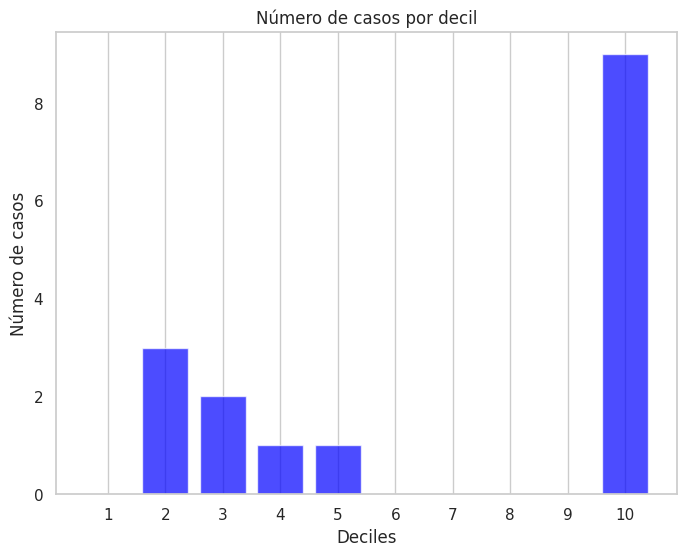

In [ ]:
# Obtener el valor de lift del rendimiento anterior
lift_xgb = rendimiento_antes_xgb.gains_lift()['lift']

# Calcular los deciles
deciles_xgb = np.percentile(lift_xgb, np.arange(0, 101, 10))

# Contar cuántos casos caen en cada intervalo de deciles
count_deciles_xgb = np.histogram(lift_xgb, bins=deciles_xgb)[0]

# Graficar el gráfico de LIFT en deciles
plt.figure(figsize=(8, 6))
plt.bar(range(1, 11), count_deciles_xgb, color='blue', alpha=0.7)
plt.xlabel('Deciles')
plt.ylabel('Número de casos')
plt.title('Número de casos por decil')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()

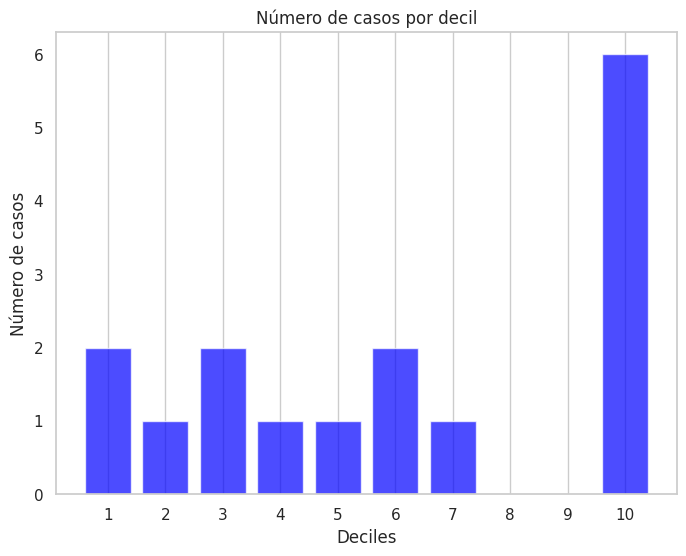

In [ ]:
# Obtener el valor de lift del rendimiento anterior
lift_rrnn = rendimiento_antes_rrnn.gains_lift()['lift']

# Calcular los deciles
deciles_rrnn = np.percentile(lift_rrnn, np.arange(0, 101, 10))

# Contar cuántos casos caen en cada intervalo de deciles
count_deciles_rrnn = np.histogram(lift_rrnn, bins=deciles)[0]

# Graficar el gráfico de LIFT en deciles
plt.figure(figsize=(8, 6))
plt.bar(range(1, 11), count_deciles_rrnn, color='blue', alpha=0.7)
plt.xlabel('Deciles')
plt.ylabel('Número de casos')
plt.title('Número de casos por decil')
plt.xticks(range(1, 11))
plt.grid(axis='y')
plt.show()

SCORER:

In [ ]:
rendimiento_antes_xgb.F1()


[[0.5226632356643677, 0.9725274725274725]]

In [ ]:
rendimiento_antes_rrnn.F1()

[[0.9994321837852118, 0.9136029411764706]]

In [ ]:
## Otras evaluaciones comunes ##
precision = rendimiento_antes_xgb.precision()
recall = rendimiento_antes_xgb.recall()
accuracy = rendimiento_antes_xgb.accuracy()
especificidad = rendimiento_antes_xgb.specificity()
auc_pr = rendimiento_antes_xgb.aucpr()

print(" 1) Precisión: "+ str(precision))
print(" 2) Recall (Sensibilidad): "+ str(recall))

print(" 3) Exactitud (Accuracy): ", accuracy)
print(" 4) Especificidad: ", especificidad)
print(" 5) AUC-PR:", auc_pr)

 1) Precisión: [[0.9998495519161225, 1.0]]
 2) Recall (Sensibilidad): [[0.012755908071994781, 1.0]]
 3) Exactitud (Accuracy):  [[0.5226632356643677, 0.9733333333333334]]
 4) Especificidad:  [[0.9998495519161225, 1.0]]
 5) AUC-PR: 0.994869384613999


In [ ]:
## Otras evaluaciones comunes ##
precision = rendimiento_antes_rrnn.precision()
recall = rendimiento_antes_rrnn.recall()
accuracy = rendimiento_antes_rrnn.accuracy()
especificidad = rendimiento_antes_rrnn.specificity()
auc_pr = rendimiento_antes_rrnn.aucpr()

print(" 1) Precisión: "+ str(precision))
print(" 2) Recall (Sensibilidad): "+ str(recall))

print(" 3) Exactitud (Accuracy): ", accuracy)
print(" 4) Especificidad: ", especificidad)
print(" 5) AUC-PR:", auc_pr)

 1) Precisión: [[0.9999939175272661, 1.0]]
 2) Recall (Sensibilidad): [[0.9837586728348661, 1.0]]
 3) Exactitud (Accuracy):  [[0.9994321837852118, 0.9164444444444444]]
 4) Especificidad:  [[0.9999939175272661, 1.0]]
 5) AUC-PR: 0.9681751914426258
